In [1]:
import pandas as pd
import numpy as np
import math
import yfinance as yf
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
import warnings
from sklearn.linear_model import LinearRegression
from scipy.stats import norm

warnings.filterwarnings("ignore")

In [2]:
data_nse=yf.download("^NSEI","2012-07-01","2023-12-31")
data_nse.to_csv('output.csv', index=False)

[*********************100%%**********************]  1 of 1 completed


In [3]:
data_nse

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-07-02,5283.850098,5302.149902,5263.350098,5278.600098,5278.600098,0
2012-07-03,5298.850098,5317.000000,5265.950195,5287.950195,5287.950195,0
2012-07-04,5310.399902,5317.649902,5273.299805,5302.549805,5302.549805,0
2012-07-05,5297.049805,5333.649902,5288.850098,5327.299805,5327.299805,0
2012-07-06,5324.700195,5327.200195,5287.750000,5316.950195,5316.950195,0
...,...,...,...,...,...,...
2023-12-22,21295.849609,21390.500000,21232.449219,21349.400391,21349.400391,284700
2023-12-26,21365.199219,21477.150391,21329.449219,21441.349609,21441.349609,219500
2023-12-27,21497.650391,21675.750000,21495.800781,21654.750000,21654.750000,256500


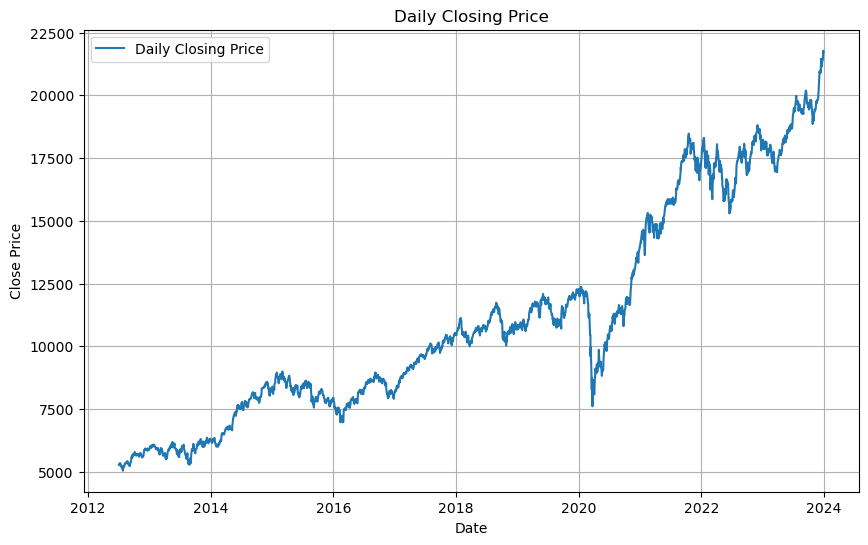

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(data_nse.index, data_nse["Close"], label="Daily Closing Price")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Daily Closing Price')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
def compute_log_returns(df):
    log_prices = np.log(df['Close'])
    log_returns = log_prices.diff().dropna()
    sigma = log_returns.std()
    normalized_log_returns = log_returns / sigma
    return normalized_log_returns

normalized_log_returns = compute_log_returns(data_nse)

In [6]:
print(normalized_log_returns)

Date
2012-07-03    0.169013
2012-07-04    0.263306
2012-07-05    0.444718
2012-07-06   -0.185714
2012-07-09   -0.753764
                ...   
2023-12-22    0.422982
2023-12-26    0.410426
2023-12-27    0.945794
2023-12-28    0.545075
2023-12-29   -0.207633
Name: Close, Length: 2819, dtype: float64


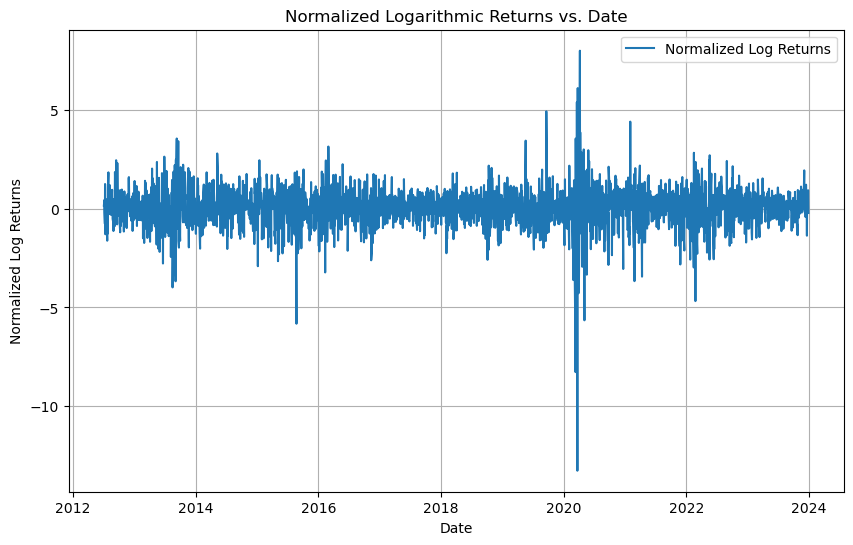

In [7]:
normalized_log_returns = pd.Series(normalized_log_returns, index=data_nse.index[1:])
plt.figure(figsize=(10, 6))
plt.plot(normalized_log_returns.index, normalized_log_returns.values, label='Normalized Log Returns')
plt.xlabel('Date')
plt.ylabel('Normalized Log Returns')
plt.title('Normalized Logarithmic Returns vs. Date')
plt.legend()
plt.grid(True)
plt.show()


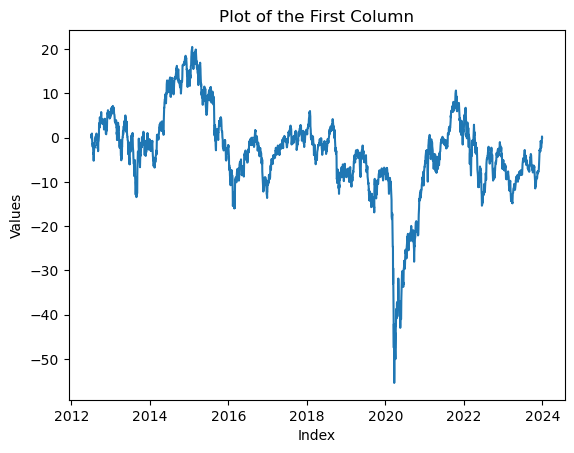

In [125]:
def calculate_profile(normalized_log_returns):
    mean_log_return = normalized_log_returns.mean()
    centered_log_returns = normalized_log_returns - mean_log_return
    profile = centered_log_returns.cumsum()
    return profile



profile = calculate_profile(normalized_log_returns)
# print(profile)
plt.plot(profile)  
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Plot of the First Column')
plt.show()

In [10]:
def divide_profile(profile, scale):
    N = len(profile)
    Ns = int(N / scale)
    
    segments = []
    for i in range(Ns):
        segment = profile[i * scale : (i + 1) * scale]
        segments.append(segment)

    for i in range(Ns):
        segment = profile[N - (i + 1) * scale : N - i * scale]
        segments.append(segment[::-1])  # Reverse the segment to start from the end

    return segments, Ns

In [12]:
def calculate_local_trend_and_variance(segments, scale, Ns):
    variances = []

    for ν in range(2 * Ns):
        segment = segments[ν]
        time = np.arange(scale)
        
        # Fit a least-squares polynomial (degree 1 for a linear fit)
        p = Polynomial.fit(time, segment, deg=1)
        trend = p(time)
        
        # Calculate the variance for the segment
        if ν < Ns:
            variance = np.sum((segment - trend)**2) / scale
        else:
            variance = np.sum((segment - trend[::-1])**2) / scale  # Reverse trend for segments from the end
        
        variances.append(variance)
    
    return variances

In [15]:
def calculate_fluctuation_function(variances, Ns, q):
    if q == 0:
        # For q=0, use a logarithmic approach (not defined in the initial request but included for completeness)
        fluctuation_function = np.exp(np.sum(np.log(variances)) / (2 * Ns))
    else:
        fluctuation_function = (np.mean(np.power(variances, q / 2)) / (2 * Ns)) ** (1 / q)
    
    return fluctuation_function

  scale        Fq
0     3  0.019985
1     4  0.026916
2     5  0.033883
3     6  0.041133
4     7  0.049308


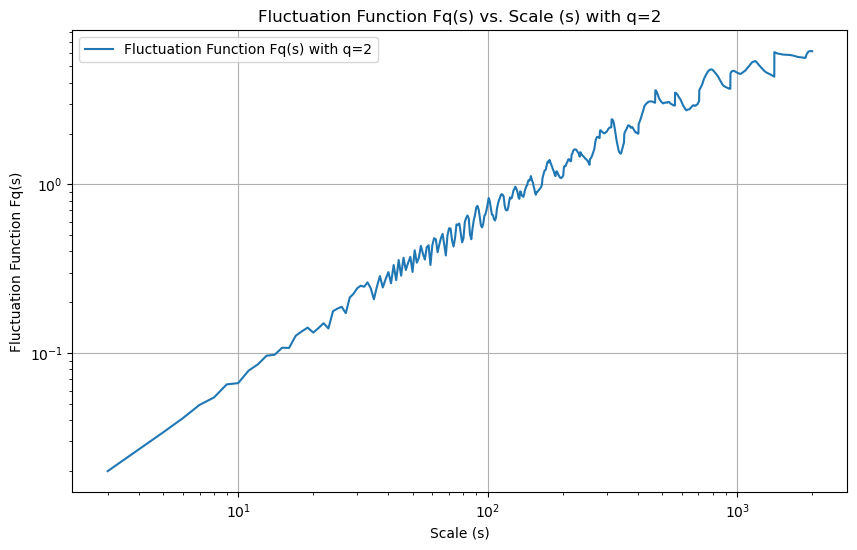

In [18]:
results_df = pd.DataFrame(columns=['scale', 'Fq'])

q = 2  # Keeping q constant


for scale in range(3, 2001):
    
    segments, Ns = divide_profile(profile, scale)
    
   
    variances = calculate_local_trend_and_variance(segments, scale, Ns)
    
    
    fluctuation_function = calculate_fluctuation_function(variances, Ns, q)
    
    
    results_df = pd.concat([results_df, pd.DataFrame({'scale': [scale], 'Fq': [fluctuation_function]})], ignore_index=True)


print(results_df.head())


plt.figure(figsize=(10, 6))
plt.loglog(results_df['scale'], results_df['Fq'], label='Fluctuation Function Fq(s) with q=2')
plt.xlabel('Scale (s)')
plt.ylabel('Fluctuation Function Fq(s)')
plt.title('Fluctuation Function Fq(s) vs. Scale (s) with q=2')
plt.legend()
plt.grid(True)
plt.show()

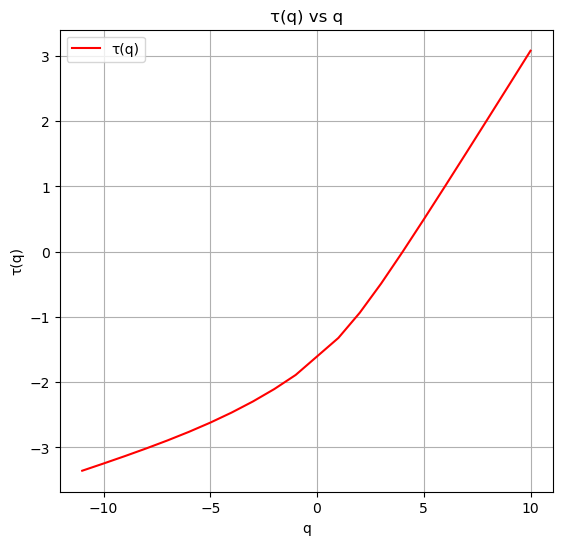

q = -11
Scale = 150, log(Fq)/log(s) = 0.1694605013421834
Scale = 200, log(Fq)/log(s) = 0.23963367326149898
Scale = 250, log(Fq)/log(s) = 0.23366207153709517
q = -10
Scale = 150, log(Fq)/log(s) = 0.18158777052882744
Scale = 200, log(Fq)/log(s) = 0.24899231157730403
Scale = 250, log(Fq)/log(s) = 0.24328988819154343
q = -9
Scale = 150, log(Fq)/log(s) = 0.196066636678837
Scale = 200, log(Fq)/log(s) = 0.2600832088368155
Scale = 250, log(Fq)/log(s) = 0.25477304009753654
q = -8
Scale = 150, log(Fq)/log(s) = 0.21361257170418493
Scale = 200, log(Fq)/log(s) = 0.27344948633911126
Scale = 250, log(Fq)/log(s) = 0.2686410725740695
q = -7
Scale = 150, log(Fq)/log(s) = 0.23527280915086154
Scale = 200, log(Fq)/log(s) = 0.28991787045732953
Scale = 250, log(Fq)/log(s) = 0.2856489350768545
q = -6
Scale = 150, log(Fq)/log(s) = 0.26267830267414205
Scale = 200, log(Fq)/log(s) = 0.3108354711633013
Scale = 250, log(Fq)/log(s) = 0.30696270084152416
q = -5
Scale = 150, log(Fq)/log(s) = 0.29860966055045185
Scale 

In [126]:
results_df = pd.DataFrame(columns=['q', 'logFq_over_log_s'])

q_values = range(-11,11) 
scales = [150,200,250]


individual_logFq_over_log_s = {q: {scale: None for scale in scales} for q in q_values}

for q in q_values:
    # if q in range(-1,22):
    #     continue
    if q==0:
        continue
    logFq_over_log_s = []
    
    for scale in scales:
        
        segments, Ns = divide_profile(profile, scale)
        
        
        variances = calculate_local_trend_and_variance(segments, scale, Ns)
        
        
        fluctuation_function = calculate_fluctuation_function(variances, Ns, q)
        
       
        log_value = np.log(fluctuation_function) / np.log(scale)
        logFq_over_log_s.append(log_value)
        
        
        individual_logFq_over_log_s[q][scale] = log_value
    
    
    avg_logFq_over_log_s = np.mean(logFq_over_log_s)
    
    
    results_df = pd.concat([results_df, pd.DataFrame({'q': [q], 'logFq_over_log_s': [avg_logFq_over_log_s]})], ignore_index=True)


results_df.replace([np.inf, -np.inf], np.nan, inplace=True)
results_df.dropna(inplace=True)

results_df['h(q)'] = results_df['logFq_over_log_s']


results_df['τ(q)'] = results_df['q'] * results_df['h(q)'] - 1

results_df['α'] = np.gradient(results_df['τ(q)'], results_df['q'])
results_df['f(α)'] = results_df['q'] * (results_df['α'] - results_df['h(q)']) + 1

plt.figure(figsize=(14, 6))

# Plot h(q)
plt.subplot(1, 2, 1)
plt.plot(results_df['q'], results_df['h(q)'], label='h(q)')
plt.xlabel('q')
plt.ylabel('h(q)')
plt.title('h(q) vs q')
plt.legend()
plt.grid(True)
y_center = (results_df['h(q)'].max() + results_df['h(q)'].min()) / 2
plt.ylim(y_center - 10, y_center + 10)

# # Plot τ(q)
plt.subplot(1, 2, 2)
plt.plot(results_df['q'], results_df['τ(q)'], label='τ(q)', color='red')
plt.xlabel('q')
plt.ylabel('τ(q)')
plt.title('τ(q) vs q')
plt.legend()
plt.grid(True)


# plt.tight_layout()
plt.show()
for q in q_values:
    print(f"q = {q}")
    for scale in scales:
        print(f"Scale = {scale}, log(Fq)/log(s) = {individual_logFq_over_log_s[q][scale]}")

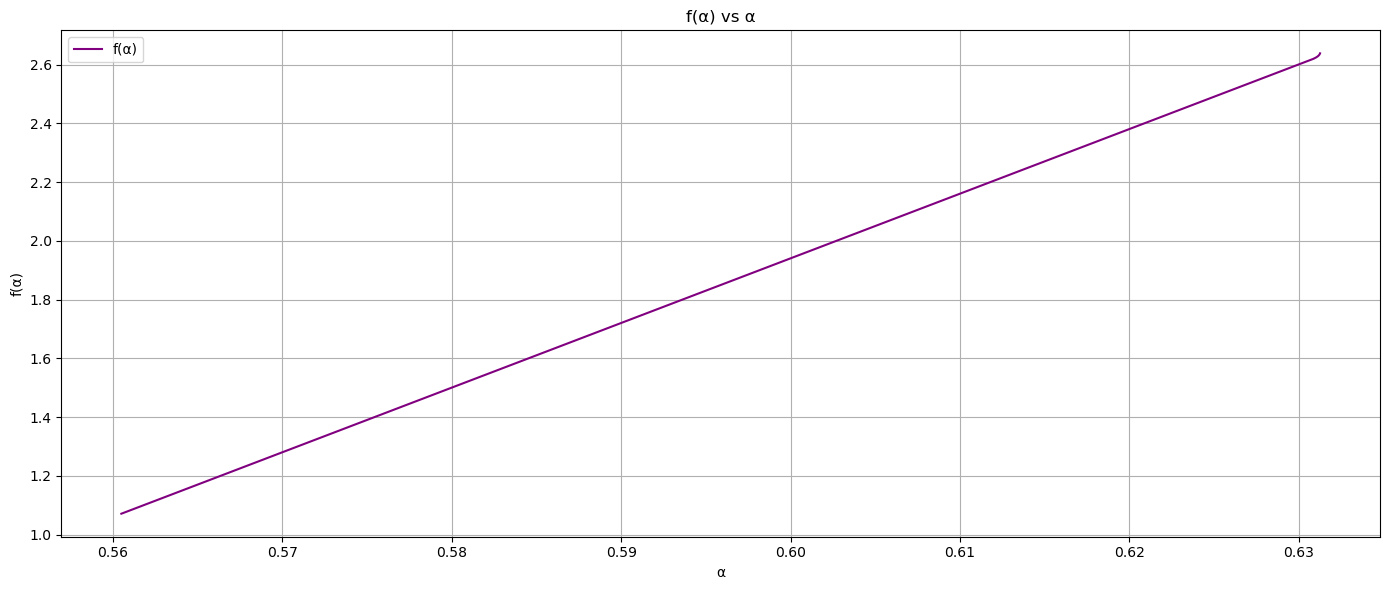

0      1.071494
1      2.554220
2      2.616594
3      2.617718
4      2.618727
         ...   
187    2.638368
188    2.638372
189    2.638377
190    2.638381
191    2.638383
Name: f(α), Length: 192, dtype: float64


In [122]:
results_df = pd.DataFrame(columns=['q', 'logFq_over_log_s'])

q_values = range(-2,500) 
scales = range(100,130)


individual_logFq_over_log_s = {q: {scale: None for scale in scales} for q in q_values}

for q in q_values:
    if q in range(-1,22):
        continue
    # if q==0:
    #     continue
    logFq_over_log_s = []
    
    for scale in scales:
        
        segments, Ns = divide_profile(profile, scale)
        
        
        variances = calculate_local_trend_and_variance(segments, scale, Ns)
        
        
        fluctuation_function = calculate_fluctuation_function(variances, Ns, q)
        
       
        log_value = np.log(fluctuation_function) / np.log(scale)
        logFq_over_log_s.append(log_value)
        
        
        individual_logFq_over_log_s[q][scale] = log_value
    
    
    avg_logFq_over_log_s = np.mean(logFq_over_log_s)
    
    
    results_df = pd.concat([results_df, pd.DataFrame({'q': [q], 'logFq_over_log_s': [avg_logFq_over_log_s]})], ignore_index=True)


results_df.replace([np.inf, -np.inf], np.nan, inplace=True)
results_df.dropna(inplace=True)

results_df['h(q)'] = results_df['logFq_over_log_s']


results_df['τ(q)'] = results_df['q'] * results_df['h(q)'] - 1

results_df['α'] = np.gradient(results_df['τ(q)'], results_df['q'])
results_df['f(α)'] = results_df['q'] * (results_df['α'] - results_df['h(q)']) + 1

plt.figure(figsize=(14, 6))

# plt.subplot(1, 4, 3)
plt.plot(results_df['α'], results_df['f(α)'], label='f(α)', color='purple')
plt.xlabel('α')
plt.ylabel('f(α)')
plt.title('f(α) vs α')
plt.legend()
plt.grid(True)
# y_center = (results_df['f(α)'].max() + results_df['f(α)'].min()) / 2
# plt.ylim(y_center - 0.05, y_center + 0.05)


plt.tight_layout()
plt.show()
# for q in q_values:
#     print(f"q = {q}")
#     for scale in scales:
#         print(f"Scale = {scale}, log(Fq)/log(s) = {individual_logFq_over_log_s[q][scale]}")
print(results_df["f(α)"])